# Curated dataset of airfoils
We developed a curated set of airfoils with various characteristics that can inform the data-driven parameter space. We begin by gathering airfoils from the extensive BigFoil database, which is a large database that consolidates airfoil data from the University of Illinois Urbana-Champaign (UIUC) airfoil database~, the JavaFoil database, the NACA-TR-824 database, and other sources. The diverse origins of these airfoils mean that, while they cover a wide range of interesting features worth studying, airfoil landmark data can often be sparse, noisy, or incomplete. To ensure a reasonable design space of airfoils, we performed a pre-processing to clean the data and identify undesirable shape characteristics unsuitable for this analysis. Specifically, we removed airfoils with too few landmarks to adequately describe the shape and those whose landmarks appeared to be noisy. We also removed airfoils with shape characteristics outside of this work interest---e.g., airfoils with a sharp leading edge and those exceeding a threshold for trailing edge thickness. Further, we note that the BigFoil dataset contains a disproportionate number of variations of NACA airfoils. Specially, it contains parametric sweeps of NACA airfoils with increasing thickness and camber. To avoid a bias towards these shapes in our design space, we thinned out the collection of these airfoils by selecting every fourth step in the parameter sweeps. The final step involves regularizing the airfoils by fitting the shapes with a CST parametrization and then removing airfoils with high reconstruction errors. This data pre-processing resulted in a set of 6,164 airfoils.

To augment this data set, we also generated additional airfoils using CST parametrization. We identified 13 baseline airfoils from the NREL 5MW and IEA 15MW reference wind turbines and used least-squares fits of CST parametrizations with fixed order $p=8$ (for upper and lower surfaces) to reparametrize and sample shape landmarks. We then sampled $1,000$ unique airfoils by uniformly perturbing all $18$ CST coefficients by $\pm20\%$ around the baseline for each airfoil, resulting in $13,000$ additional airfoil shapes.

The final curated database of airfoils combines the set of 6,164 airfoils from BigFoil and 13,000 airfoils defined by random perturbations to CST coefficients of baseline airfoils. Thus, we have a total of $N = 19,164$ airfoils to define data-driven design space using PGA of separable shape tensors.

This notebook shows how to access airfoils in the dataset and plots some statistical characteristics of the shapes.

In [1]:
import numpy as np
import os
import pandas as pd
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Curated airfoil shapes

In [2]:
shapes = np.load('curated_airfoils.npz')['shapes']
classes = np.load('curated_airfoils.npz')['classes']
print("shapes: ", shapes.shape)
print('classes ', classes.shape)

shapes:  (19164, 1001, 2)
classes  (19164,)


### Plotting distribution of shapes


(np.float64(-0.05),
 np.float64(1.05),
 np.float64(-0.2716830392022418),
 np.float64(0.27688397191632225))

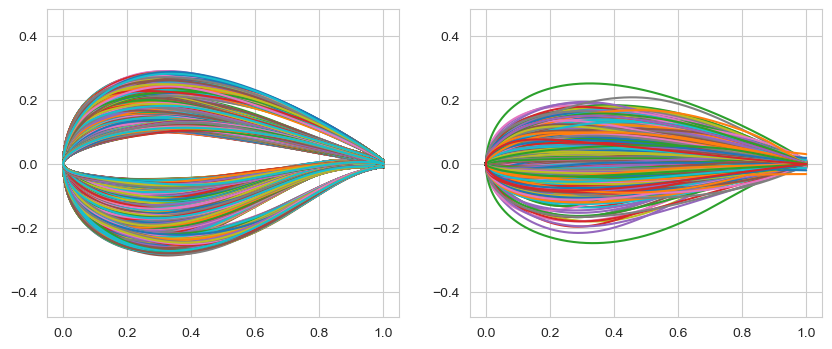

In [3]:
# Plotting shapes from 13,000 airfoils defined by 
# random perturbations to CST coefficients of baseline 
# airfoils (left) and 6,164 airfoils from BigFoil dataset.

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for shape in shapes[:13000]:
    ax[0].plot(shape[:, 0], shape[:, 1])
ax[0].axis('equal')
for shape in shapes[13000:]:
    ax[1].plot(shape[:, 0], shape[:, 1])
ax[1].axis('equal')

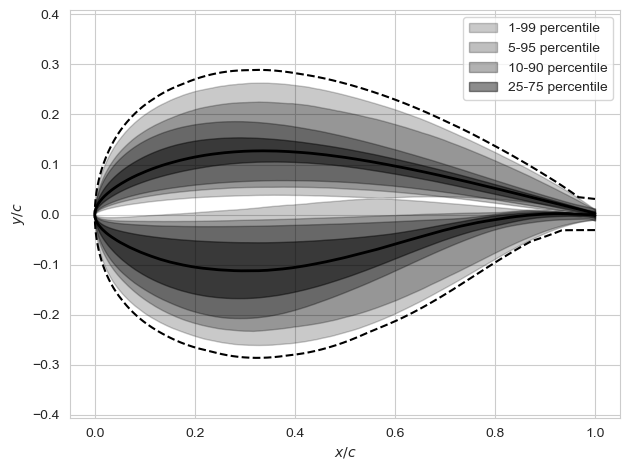

In [4]:
y_min = np.min(shapes[:, :, 1], axis=0)
y_max = np.max(shapes[:, :, 1], axis=0)
y_median = np.median(shapes[:, :, 1], axis=0)
outer = np.hstack((y_min[:501], y_max[501:]))

fig, ax = plt.subplots(1, 1)
ax.plot(shapes[0, :, 0], y_median, lw=2,  c='k')
ax.plot(shapes[0, :, 0], outer, ls='--',  c='k')
for i in [1, 5, 10, 25]:
    q1 = np.percentile(shapes[:, :, 1], q=i, axis=0)
    q2 = np.percentile(shapes[:, :, 1], q=100-i, axis=0)
    ax.fill_between(x=shapes[0, :, 0], y1=q1, y2=q2, color='k', alpha=0.2+i/100, label=f'{i}-{100-i} percentile')
plt.legend()
ax.axis('equal')
ax.set_xlabel(r"$x/c$")
ax.set_ylabel(r"$y/c$")
plt.tight_layout()

### Plot distribution of camber along the chord

In [5]:
lower_y = shapes[:, :500, 1]
lower_y = lower_y[:, ::-1]
upper_y = shapes[:, 501:, 1]

x = shapes[0, :500, 0]
x = x[::-1]

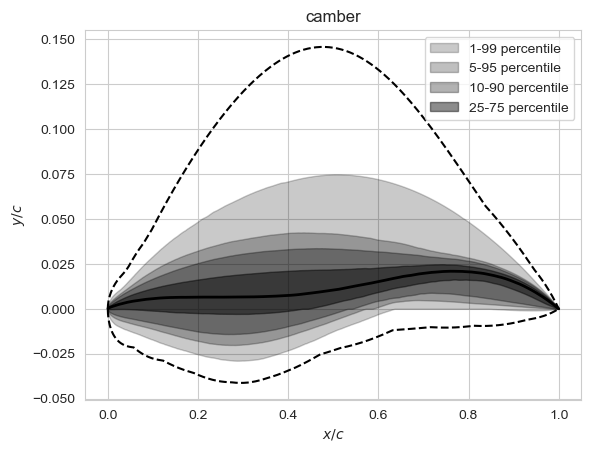

In [6]:
camber = (lower_y + upper_y)/2
camber_median = np.median(camber, axis=0)
camber_min = np.min(camber, axis=0)
camber_max = np.max(camber, axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(x, camber_median, lw=2, c='k')
ax.plot(x, camber_min, ls='--', c='k')
ax.plot(x, camber_max, ls='--', c='k')
for i in [1, 5, 10, 25]:
    q1 = np.percentile(camber, q=i, axis=0)
    q2 = np.percentile(camber, q=100-i, axis=0)
    ax.fill_between(x=x, y1=q1, y2=q2, color='k', alpha=0.2+i/100, label=f'{i}-{100-i} percentile')
ax.set_xlabel(r"$x/c$")
ax.set_ylabel(r"$y/c$")
ax.set_title('camber')
plt.legend()

### Plotting distribution of thickness along the chord

Text(0.5, 1.0, 'thickness')

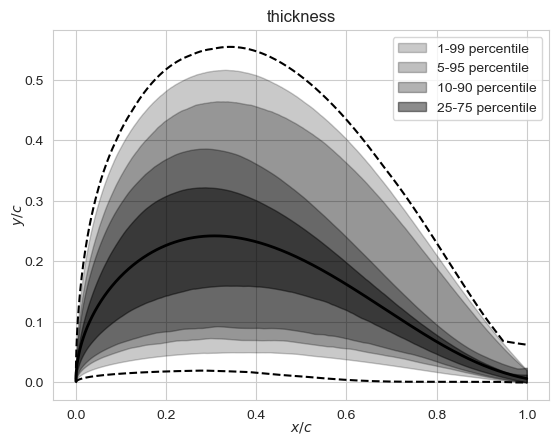

In [7]:
thickness = upper_y - lower_y
thickness_median = np.mean(thickness, axis=0)
thickness_min = np.min(thickness, axis=0)
thickness_max = np.max(thickness, axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(x, thickness_median, lw=2, c='k')
ax.plot(x, thickness_min, ls='--', c='k')
ax.plot(x, thickness_max, ls='--', c='k')
for i in [1, 5, 10, 25]:
    q1 = np.percentile(thickness, q=i, axis=0)
    q2 = np.percentile(thickness, q=100-i, axis=0)
    ax.fill_between(x=x, y1=q1, y2=q2, color='k', alpha=0.2+i/100, label=f'{i}-{100-i} percentile')
plt.legend()
ax.set_ylabel(r"$y/c$", labelpad=-2)
ax.set_xlabel(r"$x/c$", labelpad=-1)
ax.set_title('thickness')

### Plotting distribution of leading edge radius

(np.float64(0.0),
 np.float64(0.32873904282742145),
 np.float64(0.0),
 np.float64(16.9220889325646))

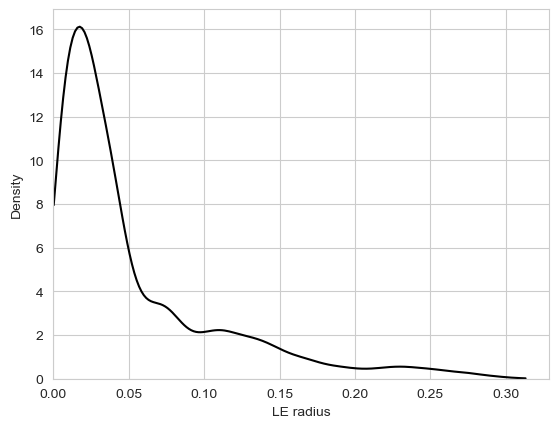

In [8]:
def arc_distance(xy):
    """Calculate distance along the arc of points defining airfoil shape. 
    t in [0, 1]

    :param xy: (n_landmarks, 2) discrete planar curve with n landmarks representing a shape
    :return: (n_landmarks, ) distance along the arc of points defining airfoil shape
    """
    dist = np.linalg.norm(np.diff(xy, axis=0), axis=1)
    t = np.cumsum(dist) / np.sum(dist)
    return np.hstack(([0.0], t))

def calc_curvature_at_x(xy):
    """Calculate curvature based on planar respresentation.

    :param xy: (n_landmarks, 2) discrete planar curve with n landmarks representing a shape
    :return: curvature values
    """
    t_phys = arc_distance(xy)
    
    s1 = CubicSpline(t_phys, xy[:, 0])
    s2 = CubicSpline(t_phys, xy[:, 1])
    t_tmp = np.linspace(0, 1, 100000)
    
    ds1, ds2 = s1(t_tmp, 1), s2(t_tmp, 1)
    dds1, dds2 = s1(t_tmp, 2), s2(t_tmp, 2)
    curvature = CubicSpline(t_tmp, ds1 * dds2 - ds2 * dds1 / (ds1 ** 2 + ds2 ** 2) ** 1.5)

    return curvature(t_phys)

delta = 1
radius = np.empty(len(shapes))
curvature = np.empty((shapes.shape[0], shapes.shape[1]))
for i, shape in enumerate(shapes):
    curvature[i] = calc_curvature_at_x(shape)
    radius[i]=np.mean(np.abs(1/curvature[i, 500-delta:501+delta]))

fig, ax = plt.subplots(1, 1)
sns.kdeplot(radius, ax=ax, cut=0, color='k')
ax.set_xlabel("LE radius")
ax.set_ylabel('Density')
ax.axis(xmin=0)

### Plotting distribution of tail edge gap size

(np.float64(0.0),
 np.float64(0.06538804075974015),
 np.float64(0.0),
 np.float64(155.0348611756263))

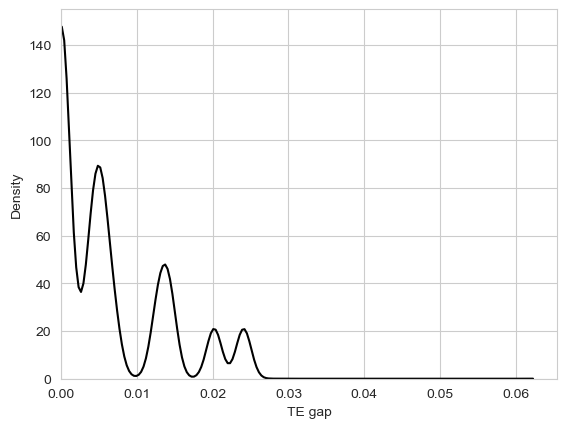

In [9]:
gap = np.empty(len(shapes))
for i, shape in enumerate(shapes):
    gap[i] = shape[-1, 1] - shape[0, 1] 

fig, ax = plt.subplots(1, 1)
sns.kdeplot(gap, ax=ax, cut=0, color='k')
ax.set_xlabel("TE gap")
ax.set_ylabel('Density')
ax.axis(xmin=0)

### Plotting distribution of maximum camber and maximum thickness and their location along the chord

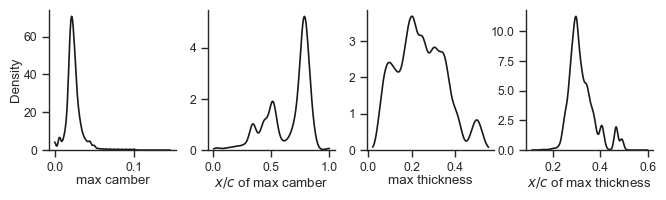

In [10]:
x_thick = x[np.argmax(thickness, axis=1)]
x_camber = x[np.argmax(camber, axis=1)]

sns.set(style="ticks")
sns.set_context("paper")
fig, ax = plt.subplots(1, 4, figsize=(6.5, 1.8))
sns.kdeplot(np.max(camber, axis=1), ax=ax[0], cut=0, color='k')
ax[0].set_xlabel("max camber", labelpad=1)
ax[0].set_ylabel('Density', labelpad=1)

sns.kdeplot(x_camber, ax=ax[1], cut=0, color='k')
ax[1].set_xlabel(r"$x/c$ of max camber", labelpad=1)
ax[1].set_ylabel('')

sns.kdeplot(np.max(thickness, axis=1), ax=ax[2], cut=0, color='k')
ax[2].set_xlabel("max thickness", labelpad=1)
ax[2].set_ylabel('')

sns.kdeplot(x_thick, ax=ax[3], cut=0, color='k')
ax[3].set_xlabel(r"$x/c$ of max thickness", labelpad=1)
ax[3].set_ylabel('')

fig.subplots_adjust(left=0.06, right=0.99, wspace=0.25,  bottom=0.2, top=0.98)
sns.despine(right=True, top=True)

### All the distributions collected in one figure

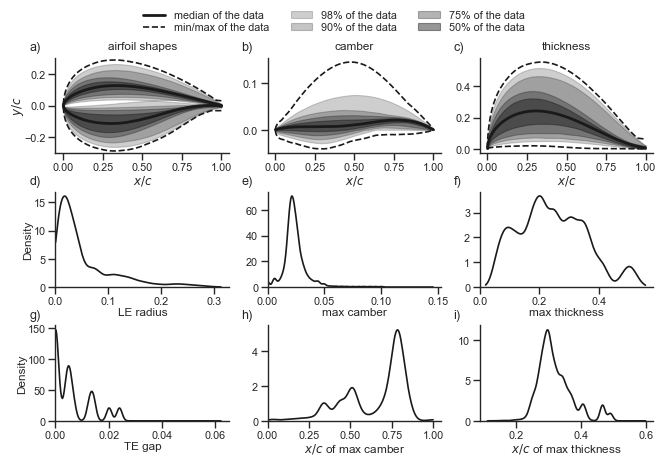

In [11]:
sns.set(style="ticks")
sns.set_context("paper", font_scale=8.5/9.6)

fig, ax = plt.subplots(3, 3, figsize=(6.5, 4.5))

#####################################################
ax[0, 0].plot(shapes[0, :, 0], y_median, lw=2,  c='k',label='median of the data')
ax[0, 0].plot(shapes[0, :, 0], outer, ls='--',  c='k', label='min/max of the data')
for i in [1, 5, 12.5, 25]:
    q1 = np.percentile(shapes[:, :, 1], q=i, axis=0)
    q2 = np.percentile(shapes[:, :, 1], q=100-i, axis=0)
    ax[0, 0].fill_between(x=shapes[0, :, 0], y1=q1, y2=q2, color='k', alpha=0.2+i/100, label=f'{int(100-2*i)}% of the data')
# plt.legend()
ax[0, 0].axis('equal')
ax[0, 0].set_xlabel(r"$x/c$", labelpad=0.5)
ax[0, 0].set_ylabel(r"$y/c$", labelpad=-1)
ax[0, 0].set_title('airfoil shapes')
ax[0, 0].tick_params(axis='both', pad=2)

#####################################################
ax[0, 1].plot(x, camber_median, lw=2, c='k')
ax[0, 1].plot(x, camber_min, ls='--', c='k')
ax[0, 1].plot(x, camber_max, ls='--', c='k')

for i in [1, 5, 12.5, 25]:
    q1 = np.percentile(camber, q=i, axis=0)
    q2 = np.percentile(camber, q=100-i, axis=0)
    ax[0, 1].fill_between(x=x, y1=q1, y2=q2, color='k', alpha=0.2+i/100, label=f'{100-2*i} percentile')

# ax[1].axis('equal')
ax[0, 1].set_xlabel(r"$x/c$", labelpad=0.5)
ax[0, 1].set_title('camber')
ax[0, 1].tick_params(axis='both', pad=2)
#####################################################
ax[0, 2].plot(x, thickness_median, lw=2, c='k', label='mean')
ax[0, 2].plot(x, thickness_min, ls='--', c='k', label='min / max')
ax[0, 2].plot(x, thickness_max, ls='--', c='k')

for i in [1, 5, 12.5, 25]:
    q1 = np.percentile(thickness, q=i, axis=0)
    q2 = np.percentile(thickness, q=100-i, axis=0)
    ax[0, 2].fill_between(x=x, y1=q1, y2=q2, color='k', alpha=0.2+i/100, label=f'{int(100-2*i)} percentile')
# ax.axis('equal')
ax[0, 2].set_xlabel(r"$x/c$", labelpad=0.5)
ax[0, 2].set_title('thickness')
ax[0, 2].tick_params(axis='both', pad=2)

ax[0, 0].legend(borderpad=0.1, borderaxespad=0, labelspacing=0.2, frameon=False, 
             bbox_to_anchor=(0.5, 1.38), loc="center left", ncol=3)
#############
#############
sns.kdeplot(radius, ax=ax[1, 0], cut=0, color='k')
ax[1, 0].set_xlabel("LE radius", labelpad=0.5)
ax[1, 0].set_ylabel('Density', labelpad=0.5)
ax[1, 0].axis(xmin=0)
ax[1, 0].tick_params(axis='both', pad=2)

sns.kdeplot(gap, ax=ax[2, 0], cut=0, color='k')
ax[2, 0].set_xlabel("TE gap", labelpad=0.5)
ax[2, 0].set_ylabel('Density', labelpad=0.5)
ax[2, 0].axis(xmin=0)
ax[2, 0].tick_params(axis='both', pad=2)
#############
#############
sns.kdeplot(np.max(camber, axis=1), ax=ax[1, 1], cut=0, color='k')
ax[1, 1].set_xlabel("max camber", labelpad=0.5)
ax[1, 1].set_ylabel('')
ax[1, 1].axis(xmin=0)
ax[1, 1].tick_params(axis='both', pad=2)

sns.kdeplot(x_camber, ax=ax[2, 1], cut=0, color='k')
ax[2, 1].set_xlabel(r"$x/c$ of max camber", labelpad=0.5)
ax[2, 1].set_ylabel('')
ax[2, 1].axis(xmin=0)
ax[2, 1].tick_params(axis='both', pad=2)

sns.kdeplot(np.max(thickness, axis=1), ax=ax[1, 2], cut=0, color='k')
ax[1, 2].set_xlabel("max thickness", labelpad=0.5)
ax[1, 2].set_ylabel('')
ax[1, 2].axis(xmin=0)
ax[1, 2].tick_params(axis='both', pad=2)

sns.kdeplot(x_thick, ax=ax[2, 2], cut=0, color='k')
ax[2, 2].set_xlabel(r"$x/c$ of max thickness", labelpad=0.5)
ax[2, 2].set_ylabel('')
ax[2, 2].tick_params(axis='both', pad=2)
#############
#############

for i in range(9):
    ax[i//3, i%3].text(-0.15, 1.17, f'{chr(ord('a') + i)})', horizontalalignment='left',
                          verticalalignment='top', transform=ax[i//3, i%3].transAxes , fontsize=9)

fig.subplots_adjust(left=0.07, right=0.99, wspace=0.22,  hspace=0.4, bottom=0.073, top=0.88)
sns.despine(right=True, top=True)

## PGA space

In [12]:
pga = np.load('PGAspace.npz')
t = pga['coords']
Vh = pga['Vh']
karcher_mean = pga['karcher_mean']
print("t:", t.shape)
print("Vh:", t.shape)
print("karcher_mean:", t.shape)

t: (19164, 1998)
Vh: (19164, 1998)
karcher_mean: (19164, 1998)


### Plotting scatterplot of pga parameters of curated airfoils

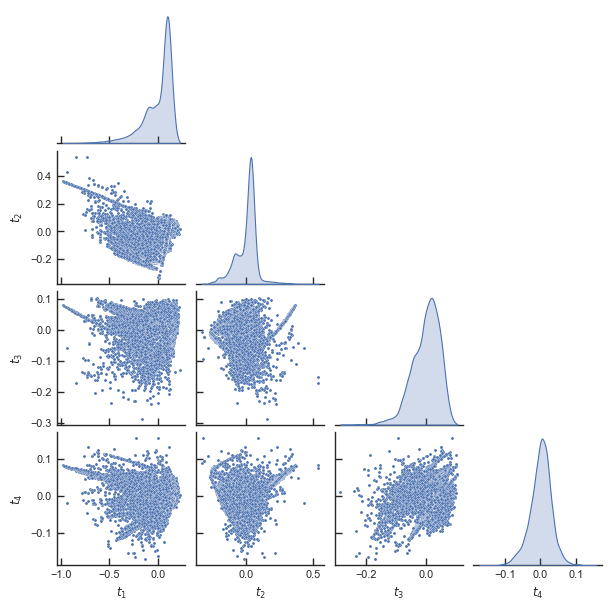

In [13]:
var_names = ['$t_1$', '$t_2$', '$t_3$', '$t_4$']
df = pd.DataFrame(data=t[:, :4], columns=var_names)
sns_plot = sns.pairplot(df, x_vars=var_names, y_vars=var_names, aspect=1, diag_kind='kde', corner=True, 
                        plot_kws=dict(s=5), diag_kws={'cut':0, "common_norm":False})
sns_plot.fig.set_size_inches(6, 6)
sns_plot.tick_params(axis='both', direction='in')


### Calculating unit normals of the karcher mean shape and plotting each mode perturbation

(18, 1001, 2)


Text(0.5, 1.0, 'Unit normals of Karcher mean shape')

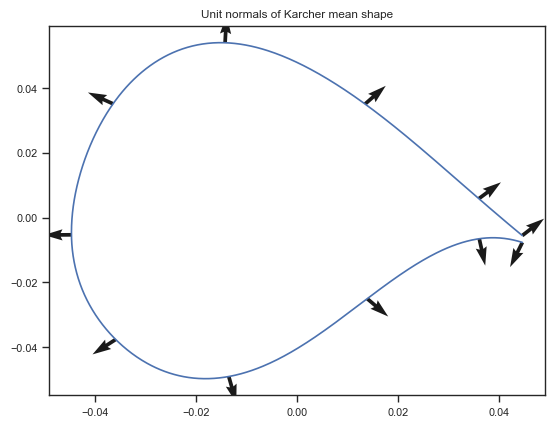

In [14]:
from g2aero.Grassmann import PGA_modes
from g2aero.utils import calc_unit_normal
import matplotlib as mpl

Vh = Vh[:18]
PGAW = Vh.reshape(len(Vh), -1, 2)
print(PGAW.shape)
modes = PGA_modes(Vh, karcher_mean, scale=0.1, sub=18)

unit_normals = calc_unit_normal(karcher_mean)
plt.plot(karcher_mean[:, 0], karcher_mean[:, 1])
plt.quiver(karcher_mean[::100, 0], karcher_mean[::100, 1], 
           10*unit_normals[::100, 0],  10*unit_normals[::100, 1])
plt.title('Unit normals of Karcher mean shape')

Visualization of shape variations (black line) about the Karcher mean (colored line) for perturbations to
each PGA parameter. The line color indicates the inner product of shape unit normal and the mode perturbation.

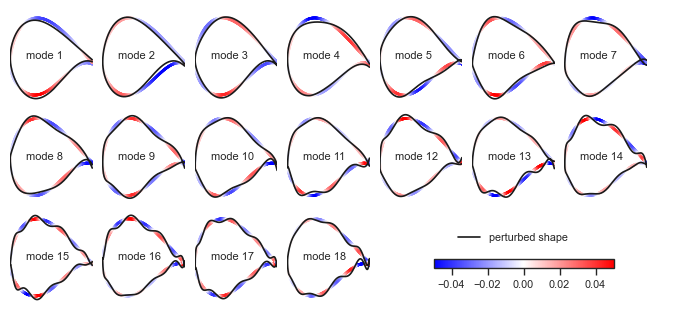

In [15]:
nrow = 7
fig, ax = plt.subplots(3, nrow, figsize=(6.5, 3.), sharey='all')
legend = 1
for i, mode in enumerate(modes):
#     unit_normals = calc_unit_normal(PGAW[i])    
    s = np.empty(len(PGAW[i]))
    for j, (n, m) in enumerate(zip(unit_normals, PGAW[i])):
        s[j] = n@m
    if legend:
        legend=0
        ax[i//nrow, i%nrow].plot(mode[:,0], mode[:,1], 'k', label='perturbed shape')
    else:
        ax[i//nrow, i%nrow].plot(mode[:,0], mode[:,1], 'k')
#     sm = plt.cm.ScalarMappable(cmap='bwr', norm=mpl.colors.Normalize(vmin=np.min(s), vmax=np.max(s)))
    sm = plt.cm.ScalarMappable(cmap='bwr', norm=mpl.colors.Normalize(vmin=-0.05, vmax=0.05))
    ax[i//nrow, i%nrow].scatter(karcher_mean[:,0], karcher_mean[:,1], s=4, color=sm.to_rgba(s), edgecolor='none')
    ax[i//nrow, i%nrow].axis(xmin=-0.045, xmax=0.045)
    ax[i//nrow, i%nrow].axis('off')
    ax[i//nrow, i%nrow].text(0.19, 0.47, f'mode {i+1}', transform=ax[i//nrow, i%nrow].transAxes, fontsize=8)

ax[-1, -1].axis('off')
ax[-1, -2].axis('off')
ax[-1, -3].axis('off')
cax = plt.axes([0.55, 0.13, 0.5, 0.03])
cax.axis('off')

fig.legend(loc='lower left', bbox_to_anchor=(0.685,0.18), frameon=False)
plt.colorbar(sm, ax=cax, fraction=1, orientation='horizontal')
fig.subplots_adjust(left=0.01, right=0.99, wspace=0.12, hspace=0.08, bottom=0.01, top=0.99)

### Plotting shape reconstruction errors over the set of curated airfoils as a function of PGA dimension

Calculating error
error shape:  (19164, 16)


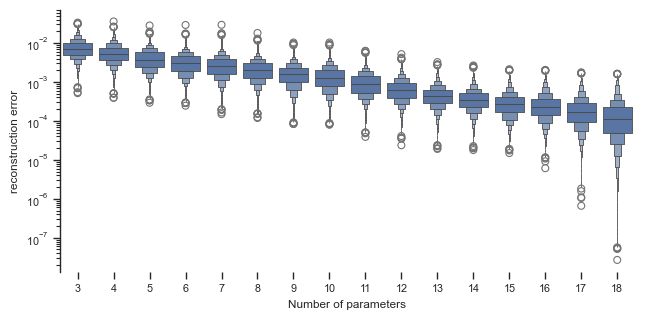

In [16]:
from g2aero.manifolds import Dataset
from g2aero.PGA import Grassmann_PGAspace

pga = Grassmann_PGAspace.load_from_file('PGAspace.npz')

def norm_inf2(sh1, sh2):
    d = np.max(np.linalg.norm(sh1-sh2, ord=2, axis=1))
    return d

def calc_err(shapes, t, pga, data, n_modes):
    print(f'Calculating error')
    r_arr = np.arange(2, n_modes)
    err_inf2 = np.zeros((len(shapes), len(r_arr)))
    for i, r in enumerate(r_arr):
        for j, coord in enumerate(t[:, :r]): 
            phys_shape = pga.PGA2shape(coord, M=data.M[j], b=data.b[j], original_shape_gr=data.shapes_gr[j])
            err_inf2[j, i] = norm_inf2(phys_shape, shapes[j])
    return err_inf2


# 100 shapes
data = Dataset(shapes)

# Calculate error
err_inf2 = calc_err(shapes, t, pga, data, 18)
print("error shape: ", err_inf2.shape)
column_names = [f'{i+3}' for i in range(err_inf2.shape[1])]
df = pd.DataFrame(data = err_inf2, columns = column_names)
df_long = df.melt(var_name="Number of parameters", value_name="reconstruction error")

g = sns.catplot(data=df_long, x='Number of parameters', y='reconstruction error', kind="boxen", height=6.5/2, aspect=2)
g.ax.set_yscale('log')
sns.despine(bottom=True)